In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import os
import sys
sys.path.insert(0, os.path.abspath('../bgflow'))
print(sys.path)

['/home/weigel/proj/machine_learning/machine_learning_muca/bgflow', '/home/weigel/proj/machine_learning/machine_learning_muca/notebooks', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.9/dist-packages']


In [5]:
# first define system dimensionality and a target energy/distribution

dim = 2

from bgflow import DoubleWellEnergy

target = DoubleWellEnergy(dim)

In [7]:
# define a MCMC sampler to sample from the target energy

from bgflow import GaussianMCMCSampler

init_state = torch.Tensor([[-2, 0], [2, 0]])
init_state = torch.cat([init_state, torch.Tensor(init_state.shape[0], dim-2).normal_()], dim=-1)
target_sampler = GaussianMCMCSampler(target, init_state=init_state)

In [18]:
# sample some data 

data = target_sampler.sample(5000)

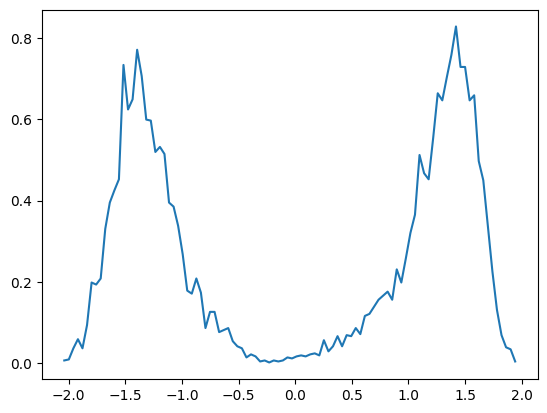

In [19]:
hist, bins = np.histogram(data[:,0], 100, density=True)
plt.plot(bins[:-1], hist)

In [ ]:
hist, bins = np.histogram(assert_numpy(samples[:,0]), 100, density=True)
plt.plot(bins[:-1], hist)

In [20]:
def GMM_wrapper(x, N, *args):
    return GMM(x, args[0][:N], args[0][N:2*N], args[0][2*N:3*N])
    
def GMM(x, x0, sigma, pi):
    x0 = np.array(x0)
    sigma = np.array(sigma)
    pi = np.array(pi)
    assert(len(x0) == len(sigma))
    assert(len(sigma) == len(pi))
    pi /= np.sum(pi)
    #print("x0 equals {}" .format(x0))
    #print("x equals {}" . format(x))
    #print ( np.sum(pi/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x[:,np.newaxis]-x0)**2/(2*sigma**2))) )
    return np.sum(pi/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x[:,np.newaxis]-x0)**2/(2*sigma**2)),axis=1)

In [43]:
from scipy.optimize import curve_fit
N = 4
params_0 = np.ravel([np.random.choice(bins,size=N), np.ones(N), np.full(N,1/N)])
#print(params_0)
bounds = (np.ravel([np.full(N,-np.inf), np.full(N,-np.inf), np.zeros(N)]),
          np.ravel([np.full(N,+np.inf), np.full(N,+np.inf), np.ones(N)]))
#print(bounds)
#print("bins is  {}" .format(bins[:-1]))
popt, pcov = curve_fit(lambda x, *p0: GMM_wrapper(x, N, p0), bins[:-1], hist, p0 = params_0, bounds = bounds)

In [44]:
popt[2*N:3*N]

array([0.47057571, 0.28619947, 0.53330866, 0.32644743])

In [41]:
values = GMM_wrapper(bins[:-1],N,popt)

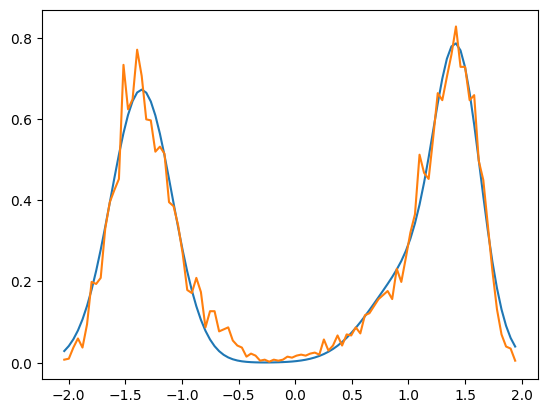

In [42]:
plt.plot(bins[:-1], values)
plt.plot(bins[:-1], hist)
plt.show()